In [302]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from scipy import stats
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [181]:
# 데이터 로드 및 시간데이터 인덱싱
data = sm.datasets.get_rdataset("AirPassengers")
raw = data.data.copy()

if 'time' in raw.columns:
    raw.index = pd.date_range(start='1/1/1949', periods=len(raw['time']), freq='M')
    del raw['time']

raw.head()

,value
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


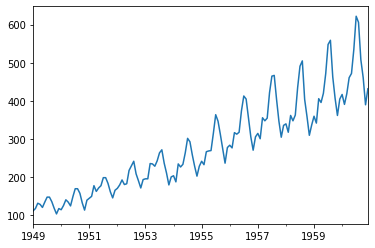

In [182]:
# 데이터 확인
raw.value.plot()

ADF :  0.8153688792060418   p-value :  0.9918802434376409
KPSS :  1.0521750110135095   p-value :  0.01


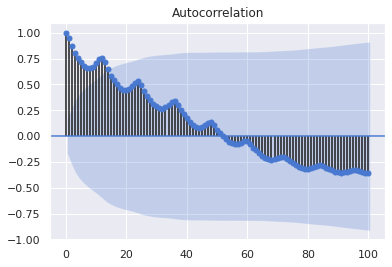

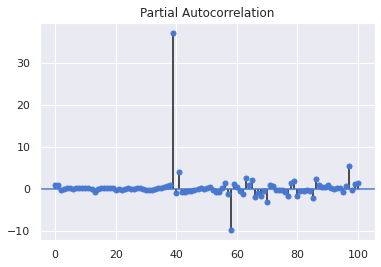

In [341]:
# 정상성 확인

def check(data, i) :
  adf = sm.tsa.adfuller(data)
  kpss = sm.tsa.kpss(data)

  print('ADF : ', adf[0], '  p-value : ', adf[1])
  print('KPSS : ', kpss[0], '  p-value : ', kpss[1])
  
  sm.graphics.tsa.plot_acf(data, lags=i, use_vlines=True)
  sm.graphics.tsa.plot_pacf(data, lags=i, use_vlines=True)
  plt.show()

check(raw.value, 100)

ADF :  -1.7170170891069612   p-value :  0.4223667747703909
KPSS :  1.053981419846458   p-value :  0.01


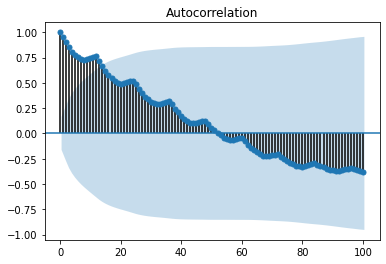

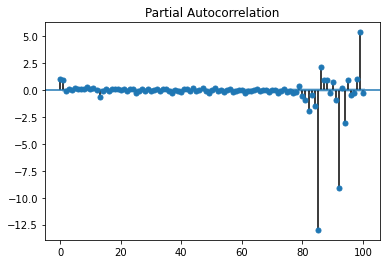

,value
1949-01-31,4.718499
1949-02-28,4.770685
1949-03-31,4.882802
1949-04-30,4.859812
1949-05-31,4.795791


In [184]:
# 로그 변환
raw_log = np.log(raw).copy()

check(raw_log.value, 100)
raw_log.head()

ADF :  -2.7171305983881044   p-value :  0.07112054815086355
KPSS :  0.1015445868740261   p-value :  0.1


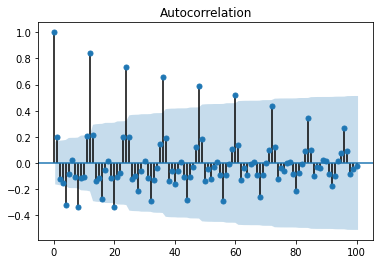

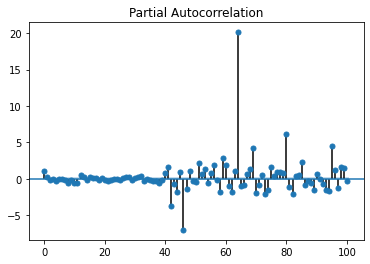

,value
1949-02-28,0.052186
1949-03-31,0.112117
1949-04-30,-0.022990
1949-05-31,-0.064022
1949-06-30,0.109484


In [185]:
# 로그변환 + 추세차분
raw_log_diff = raw_log.diff(1).dropna().copy()
check(raw_log_diff.value, 100)
raw_log_diff.head()

ADF :  -4.443324941831122   p-value :  0.00024859123113840637
KPSS :  0.10882483003768782   p-value :  0.1


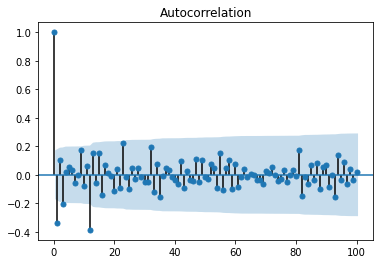

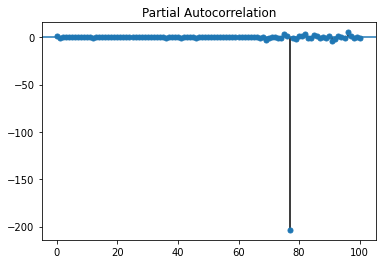

In [186]:
# 로그변환 + 추세차분 + 계절차분
raw_log_diff_ss = raw_log_diff.diff(12).dropna().copy()
check(raw_log_diff_ss.value, 100)

In [189]:
# train / test split
# 위 과정으로 로그변환, 추세차분, 계절차분이 필요한걸 알게 되었으니까 로그변환을 취한 데이터에 SARIMA 모델 적용!!!!!
final = raw_log.copy()

split_date = '1958-01-01'
y_train = final[final.index < split_date]
y_test = final[final.index >= split_date]

ADF :  -0.9974327811794589   p-value :  0.7541994832280583
KPSS :  0.8673961508860023   p-value :  0.01


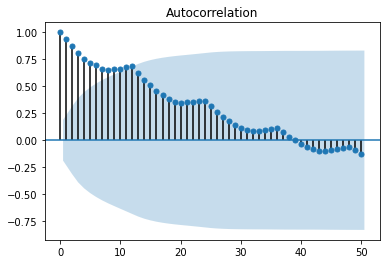

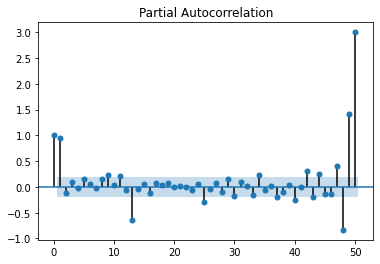

In [190]:
# y_train 시각화
check(y_train.value, 50)

# 그래프보고 파라미터 추정

In [191]:
# 모델링 및 예측
model = sm.tsa.SARIMAX(y_train, order=(1,1,0), seasonal_order=(1,0,1,12), trend='c').fit()
train_pred = model.predict() # 학습데이터에 대한 점추정
test_pred = model.get_forecast(len(y_test)).predicted_mean # 테스트 기간에 대한 점 추정
test_ci_pred = model.get_forecast(len(y_test)).conf_int() # 테스트 기간에 대한 구간 추정

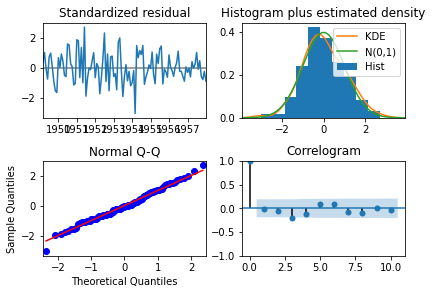

In [192]:
# 모델 시각화

model.plot_diagnostics()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) # 그래프 패딩 주기
plt.show()

In [193]:
# 비정상으로 변환

# 로그 -> exp
y_train = np.exp(y_train).copy()
y_test = np.exp(y_test).copy()
train_pred = np.exp(train_pred).copy()
test_pred = np.exp(test_pred).copy()
test_ci_pred = np.exp(test_ci_pred).copy()

# 차분 -> cumsum
# train_pred = np.cumsum(train_pred).copy()

In [195]:
# 모델 검증(Summary, MAE, MSE, train-train_pred 그래프, test-test_pred (점추정, 구간추정)그래프)
print(model.summary())

train_result = {'MAE' : mean_absolute_error(y_train, train_pred), 'MSE' : mean_squared_error(y_train,train_pred)}
test_result = {'MAE' : mean_absolute_error(y_test, test_pred), 'MSE' : mean_squared_error(y_test,test_pred)}
results = pd.DataFrame((train_result, test_result), index=['train','test'])
print(results)


                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 12)   Log Likelihood                 184.253
Date:                            Fri, 04 Jun 2021   AIC                           -358.506
Time:                                    15:30:45   BIC                           -345.142
Sample:                                01-31-1949   HQIC                          -353.089
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.330      0.741      -0.001       0.001
ar.L1         -0.2677      0.080   

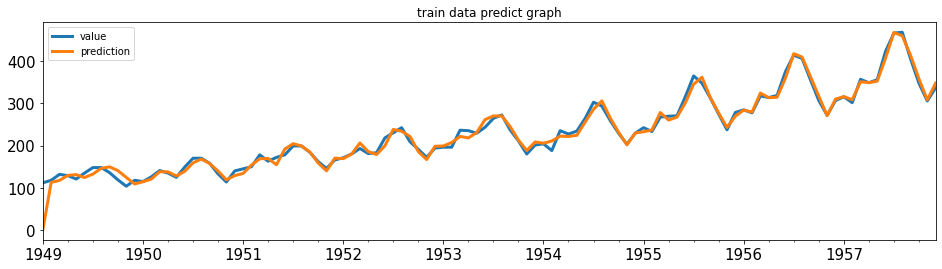

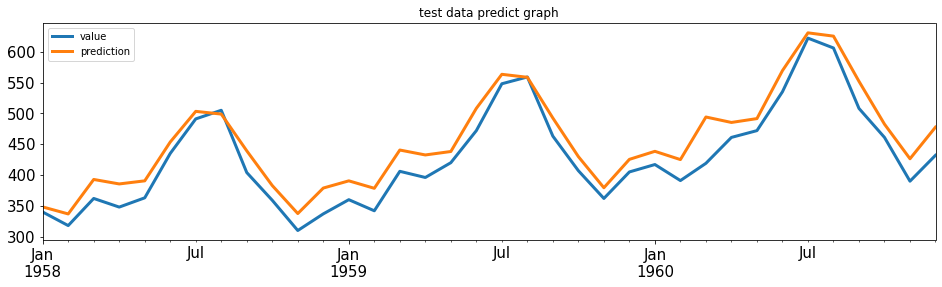

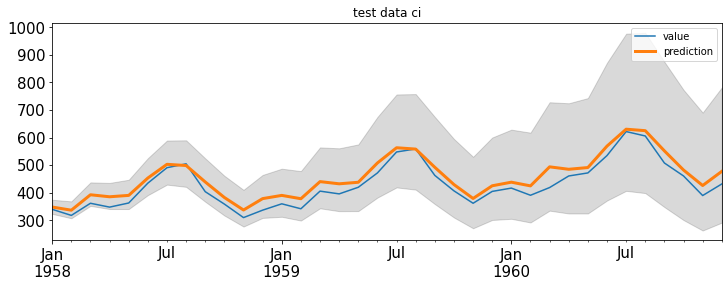

In [197]:
# 그래프로 예측값과 실제값 보기
pd.concat([y_train, pd.DataFrame(train_pred, index=y_train.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(16,4), 
                                                                                                         xlim=(y_train.index.min(), 
                                                                                                               y_train.index.max()), linewidth=3, fontsize=15)
plt.title('train data predict graph')
pd.concat([y_test, pd.DataFrame(test_pred, index=y_test.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(16,4), 
                                                                                                         xlim=(y_test.index.min(), 
                                                                                                               y_test.index.max()), linewidth=3, fontsize=15)
plt.title('test data predict graph')


ax = pd.DataFrame(y_test).plot(figsize=(12,4))
pd.DataFrame(test_pred, index=y_test.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(y_test.index.min(),y_test.index.max()),
                                                                           linewidth=3, fontsize=15, ax=ax)
ax.fill_between(pd.DataFrame(test_ci_pred, index=y_test.index).index,
                pd.DataFrame(test_ci_pred, index=y_test.index).iloc[:,0],
                pd.DataFrame(test_ci_pred, index=y_test.index).iloc[:,1], color='k', alpha=0.15)
plt.title('test data ci')

plt.show()

ADF :  -7.452692405280776   p-value :  5.616187565012326e-11
KPSS :  0.3282038308040425   p-value :  0.1


<Figure size 864x288 with 0 Axes>

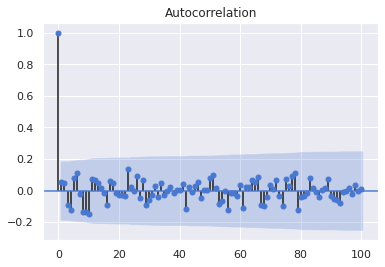

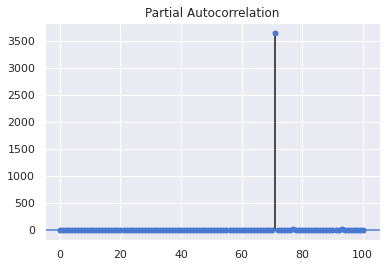

In [268]:
# 잔차검증 (정상성, 정규성, 등분산성, 자기상관성 수치) + (잔차그래프, 정규분포그래프, 시점에 대한 분산, ACF, PCF)
# ADF -> h0:정상성이 없다. 단위근이 있다
# kpss -> h0: 정상성이있다. 단위근이 없다.

train_resid = y_train.value - train_pred
test_resid = y_test.value - test_pred
train_resid = pd.DataFrame(train_resid, columns=['Error'])
test_resid = pd.DataFrame(test_resid, columns=['Error'])

check(train_resid.Error,100)

In [364]:
def error_check(y_train, train_pred) :
  train_resid = pd.DataFrame(y_train.values.flatten() - train_pred, index=y_train.index, columns=['Error'])
  y_train = y_train.loc[train_resid.index]


  # 정상성(ADF, KPSS) 및 ACF, PACF 그래프
  check(train_resid['Error'],100)

  # 등분산성 h0 : 시계열 데이터의 Homoscedasticity 상태다(등분산이다)
  gold = sm.stats.diagnostic.het_goldfeldquandt(train_resid['Error'], y_train.values, alternative='two-sided')
  print('\n\nHeteroscedasticity : ',gold[0], ' p-value : ',gold[1])

  # 잔차도, 잔차의 추세, 등분산성 알수있음
  train_resid['RowNum'] = train_resid.reset_index().index
  sns.set(palette='muted', color_codes=True, font_scale=1)
  sns.lmplot(x='RowNum', y='Error', data=train_resid, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
  del train_resid['RowNum']
  plt.show()

  # 정규성 검정 h0 : 데이터는 정규분포 형태이다
  print('shapiro : ', stats.shapiro(train_resid['Error'])[0], ' p-value : ', stats.shapiro(train_resid['Error'])[1])
  sns.distplot(train_resid['Error'], norm_hist=True, fit=stats.norm)  
  plt.show()

  # 자기상관테스트 h0 : 시계열 데이터의 Autocorrelation은 0이다(존재하지 않는다)
  auto_corr = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(train_resid['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                        pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(train_resid['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1)
  auto_corr.index = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
  print(auto_corr)

ADF :  -7.452692405280776   p-value :  5.616187565012326e-11
KPSS :  0.3282038308040425   p-value :  0.1


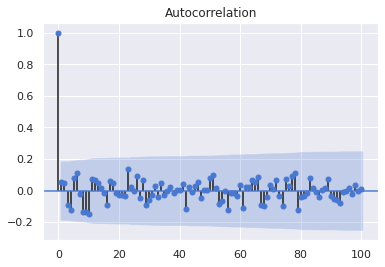

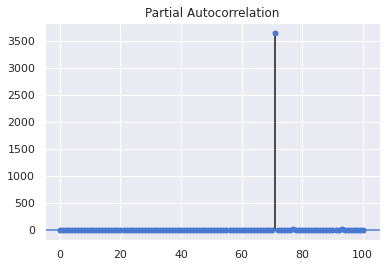



Heteroscedasticity :  0.23409487447057917  p-value :  4.3162103673803854e-07


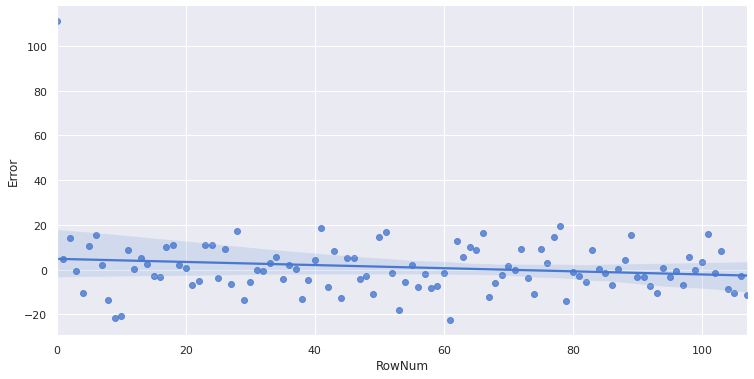

shapiro :  0.6854109764099121  p-value :  6.845182922007517e-14


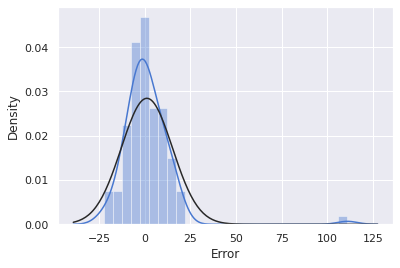

                 Test Statistics   p-value
Autocorr(lag1)          0.339885  0.559896
Autocorr(lag5)          4.168713  0.525390
Autocorr(lag10)        12.699218  0.240978
Autocorr(lag50)        29.558002  0.990552


In [365]:
error_check(y_train, train_pred)